In [1]:
#import Pkg; Pkg.add("PyCall")
#import Pkg; Pkg.add("PyPlot")
using PyCall
using PyPlot
np = pyimport("numpy")
io = pyimport("skimage.io")
pylab = pyimport("pylab")
pylab.rcParams["figure.figsize"] = (8.0, 10.0)
py"""
import sys
sys.path.insert(0, "./")
"""
pycocotools_coco = pyimport("pycocotools.coco");

In [2]:
using Plots
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using CUDA # functional
using Knet#: conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, minibatch, Data, sigm
using BenchmarkTools
using StatsBase
function Knet.KnetArray(x::CuArray{T,N}) where {T,N}
    p = Base.bitcast(Knet.Cptr, pointer(x))
    k = Knet.KnetPtr(p, sizeof(x), Int(CUDA.device().handle), x)
    KnetArray{T,N}(k, size(x))
end


# Load Images from dataset

In [3]:
dataDir="/datasets/COCO"
dataType="train2017"
annFile="$dataDir/annotations/instances_$dataType.json"
coco = pycocotools_coco.COCO(annFile);

In [4]:
catIds = coco.getCatIds(catNms=["person","dog","skateboard"]);
imgIds = coco.getImgIds(catIds=catIds);

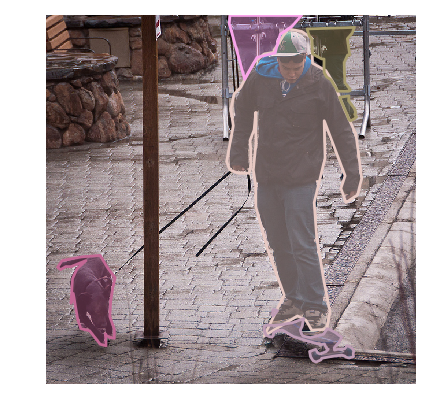

89350

In [5]:
id = imgIds[np.random.randint(1,length(imgIds))]
#id = 306440
print(id)
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
img = coco.loadImgs(id)[1]
annIds = coco.getAnnIds(imgIds=id, catIds=catIds, iscrowd=nothing)
#print(annIds);print("\n");
anns = coco.loadAnns(annIds)
#print(anns);print("\n");
I = io.imread(img["coco_url"])
plt.switch_backend("agg")
plt.axis("off")
plt.imshow(I)
plt.show()
r = coco.showAnns(anns);

In [6]:
img

Dict{Any,Any} with 8 entries:
  "file_name"     => "000000089350.jpg"
  "height"        => 640
  "id"            => 89350
  "width"         => 640
  "license"       => 3
  "date_captured" => "2013-11-18 10:52:03"
  "flickr_url"    => "http://farm7.staticflickr.com/6213/6265929440_6e26461e1e_…
  "coco_url"      => "http://images.cocodataset.org/train2017/000000089350.jpg"

In [7]:
I = permutedims(I,(2,1,3));

In [8]:
imgData = reshape(KnetArray(Float32.(I/255)),(size(I)...,1));

# Generalized R-CNN
https://medium.com/@hirotoschwert/digging-into-detectron-2-part-2-dd6e8b0526e
![Feature Pyramid Network](img/base-rcnn-fpn.png)

## Backbone Network
![Feature Pyramid Network](img/backbone-network.png)

In [9]:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) =
Conv(param(w1,w2,cx,cy;init=gaussian), param0(1,1,cy,1), f, pdrop)

Conv

In [10]:
@doc param

```
param(array; atype)
param(dims...; init, atype)
param0(dims...; atype)
```

The first form returns `Param(atype(array))`.

The second form Returns a randomly initialized `Param(atype(init(dims...)))`.  

The third form `param0` is an alias for `param(dims...; init=zeros)`.

By default, `init` is `xavier_uniform` and `atype` is `Knet.atype()`.


In [11]:
# Define a convolutional layer:
struct BasicStem; w; b; f; p; end
(bs::BasicStem)(x) =
    bs.f.(pool(conv4(bs.w, dropout(x,bs.p),stride=2,padding=3)
        .+ bs.b,window=2))
BasicStem(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) =
BasicStem(param(w1,w2,cx,cy;init=gaussian), param0(1,1,cy,1), f, pdrop)


BasicStem

### Bottleneck Blocks
![Feature Pyramid Network](img/bottleneck-blocks.png)

In [12]:
# Define a convolutional layer:
struct BottleneckBlock_a; w1; w2; w3; p; end
(this::BottleneckBlock_a)(x) = relu.(
    conv4(this.w3, dropout(
            relu.(conv4(this.w2, dropout(
                    relu.(conv4(this.w1, dropout(x,this.p)))
                    ,this.p),
                    padding=1))
            ,this.p)) .+
    x
)
BottleneckBlock_a(cx::Int,cy::Int;pdrop=0) =
    BottleneckBlock_a(
        param(1,1,cx,cy,init=gaussian), #w1
        param(3,3,cy,cy,init=gaussian), #w2
        param(1,1,cy,cx,init=gaussian), #w3
        pdrop
    )
# Define a convolutional layer:
struct BottleneckBlock_b; w0; w1; w2; w3; p; end
(this::BottleneckBlock_b)(x) = relu.(
    conv4(this.w3, dropout(
            relu.(conv4(this.w2, dropout(
                    relu.(conv4(this.w1, dropout(x,this.p)))
                    ,this.p),
                    padding=1)
                )
            ,this.p)) .+
    conv4(this.w0, dropout(x,this.p))
)
BottleneckBlock_b(cx::Int,cy::Int;pdrop=0) =
    BottleneckBlock_b(
        param(1,1,cx,cy,init=gaussian), #w0
        param(1,1,cx,cx,init=gaussian), #w1
        param(3,3,cx,cx,init=gaussian), #w2
        param(1,1,cx,cy,init=gaussian), #w3
        pdrop
    )
# Define a convolutional layer:
struct BottleneckBlock_c; w0; w1; w2; w3; p; end
(this::BottleneckBlock_c)(x) = relu.(
    conv4(this.w3, dropout(
            relu.(conv4(this.w2, dropout(
                    relu.(conv4(this.w1, dropout(x,this.p),stride=2))
                    ,this.p),
                    padding=1)
                )
            ,this.p)) .+
    conv4(this.w0, dropout(x,this.p),stride=2)
)
BottleneckBlock_c(cx::Int,cy::Int,ci::Int;pdrop=0) =
    BottleneckBlock_c(
        param(1,1,cx,cy,init=gaussian), #w0
        param(1,1,cx,ci,init=gaussian), #w1
        param(3,3,ci,ci,init=gaussian), #w2
        param(1,1,ci,cy,init=gaussian), #w3
        pdrop
    )


BottleneckBlock_c

In [13]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = sse(c(x),y)

In [14]:
conv_chain = Chain(
    BasicStem(7,7,3,64),
    BottleneckBlock_b(64,256),
    BottleneckBlock_a(256,64),
    BottleneckBlock_c(256,512,128),
    BottleneckBlock_a(512,128),
    BottleneckBlock_a(512,128),
    BottleneckBlock_a(512,128),
    BottleneckBlock_c(512,1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_a(1024,256),
    BottleneckBlock_c(1024,2048,512),
    BottleneckBlock_a(2048,4096),
    BottleneckBlock_a(2048,4096),
)

Chain((BasicStem(P(KnetArray{Float32,4}(7,7,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), Knet.Ops20.relu, 0), BottleneckBlock_b(P(KnetArray{Float32,4}(1,1,64,256)), P(KnetArray{Float32,4}(1,1,64,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,256,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0), BottleneckBlock_c(P(KnetArray{Float32,4}(1,1,256,512)), P(KnetArray{Float32,4}(1,1,256,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), Bottleneck

In [15]:
#@benchmark conv_chain(imgData)

In [16]:
struct Pyramid
    stem
    layers
    Pyramid(stem, layers...) = new(stem,layers)
end
function (p::Pyramid)(x)
    # Climbing up the pyramid
    r = p.stem(x);
    featureMaps = ();
    for l in p.layers;
        r = l(r);
        featureMaps = (featureMaps...,r);
    end
    featureMaps;
end

In [17]:
backbone = Pyramid(
    BasicStem(7,7,3,64),
    Chain(
        BottleneckBlock_b(64,256),
        BottleneckBlock_a(256,64)
        ),
    Chain(
        BottleneckBlock_c(256,512,128),
        BottleneckBlock_a(512,128),
        BottleneckBlock_a(512,128),
        BottleneckBlock_a(512,128),
        ),
    Chain(
        BottleneckBlock_c(512,1024,256),
        BottleneckBlock_a(1024,256),
        BottleneckBlock_a(1024,256),
        BottleneckBlock_a(1024,256),
        BottleneckBlock_a(1024,256),
        ),
    Chain(
        BottleneckBlock_c(1024,2048,512),
        BottleneckBlock_a(2048,4096),
        BottleneckBlock_a(2048,4096),
        ),
    Chain(
        x -> pool(x)
        )
)

Pyramid(BasicStem(P(KnetArray{Float32,4}(7,7,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), Knet.Ops20.relu, 0), (Chain((BottleneckBlock_b(P(KnetArray{Float32,4}(1,1,64,256)), P(KnetArray{Float32,4}(1,1,64,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,256,64)), P(KnetArray{Float32,4}(3,3,64,64)), P(KnetArray{Float32,4}(1,1,64,256)), 0))), Chain((BottleneckBlock_c(P(KnetArray{Float32,4}(1,1,256,512)), P(KnetArray{Float32,4}(1,1,256,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512)), 0), BottleneckBlock_a(P(KnetArray{Float32,4}(1,1,512,128)), P(KnetArray{Float32,4}(3,3,128,128)), P(KnetArray{Float32,4}(1,1,128,512

In [18]:
#@benchmark pyramid_o = backbone(imgData)

In [19]:
struct onlyConv; w; f; p; pad; end
(c::onlyConv)(x) = c.f.(conv4(c.w, dropout(x,c.p),padding=c.pad))
onlyConv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0,padding=0) =
onlyConv(param(w1,w2,cx,cy;init=gaussian), f, pdrop,padding)

onlyConv

In [20]:
struct FPN
    pyramid
    lateral_layers
    output_layers
    FPN(pyramid,lateral_layers,output_layers) =
        new(pyramid,lateral_layers,output_layers)
end
function (fpn::FPN)(x)
    # Climbing up the pyramid
    y = fpn.pyramid(x);
    L = ();
    # Reduce #channels
    for i in 1:length(fpn.lateral_layers)
        L = (L...,fpn.lateral_layers[i](y[i]))
    end
    # TODO: upsample and add
    
    # output
    O = ();
    for i in 1:length(fpn.output_layers)
        O = (O...,fpn.output_layers[i](L[i]))
    end
    (O...,L[end])
end



In [161]:
@doc pool

```
pool(x; kwargs...)
```

Compute pooling of input values (i.e., the maximum or average of several adjacent values) to produce an output with smaller height and/or width.

If `x` has dimensions `(X1,X2,...,Cx,N)`, the result `y` will have dimensions `(Y1,Y2,...,Cx,N)` where

```
Yi=1+floor((Xi+2*padding[i]-window[i])/stride[i])
```

Here `Cx` is the number of input channels, `N` is the number of instances, and `Xi,Yi` are spatial dimensions.  `window`, `padding` and `stride` are keyword arguments that can be specified as a single number (in which case they apply to all dimensions), or an array/tuple with entries for each spatial dimension.

# Keywords:

  * `window=2`: the pooling window size for each dimension.
  * `padding=0`: the number of extra zeros implicitly concatenated at the start and at the end of each dimension.
  * `stride=window`: the number of elements to slide to reach the next pooling window.
  * `mode=0`: 0 for max, 1 for average including padded values, 2 for average excluding padded values, 3 for deterministic max.
  * `maxpoolingNanOpt=1`: Nan numbers are not propagated if 0, they are propagated if 1.
  * `alpha=1`: can be used to scale the result.


In [21]:
myFPN = FPN(
    backbone,
    [
        onlyConv(1,1,256,256),
        onlyConv(1,1,512,256),
        onlyConv(1,1,1024,256),
        onlyConv(1,1,2048,256),
        onlyConv(1,1,2048,256)
    ],
    [
        onlyConv(3,3,256,256,padding=1),
        onlyConv(3,3,256,256,padding=1),
        onlyConv(3,3,256,256,padding=1),
        onlyConv(3,3,256,256,padding=1)
    ]
);

In [22]:
#@benchmark myFPN(imgData)

In [23]:
struct RPN_head
    conv_plain
    objectness_logit_conv
    anchor_deltas_conv
    RPN_head(conv_plain,objectness_logit_conv,anchor_deltas_conv) =
        new(conv_plain,objectness_logit_conv,anchor_deltas_conv)
end
function (rpnh::RPN_head)(x)
    objectness_logit = [];
    anchor_deltas = [];
    # for each head in bundle (P2 to P6)
    for h in x
        temp = rpnh.conv_plain(h)
        push!(objectness_logit, rpnh.objectness_logit_conv(temp))
        push!(anchor_deltas, rpnh.anchor_deltas_conv(temp))
    end
    (objectness_logit,anchor_deltas)
end

In [24]:
myRPN_head = RPN_head(
    onlyConv(3,3,256,256,padding=1),
    onlyConv(1,1,256,3,sigm),
    onlyConv(1,1,256,3*4)
)

RPN_head(onlyConv(P(KnetArray{Float32,4}(3,3,256,256)), Knet.Ops20.relu, 0, 1), onlyConv(P(KnetArray{Float32,4}(1,1,256,3)), Knet.Ops20.sigm, 0, 0), onlyConv(P(KnetArray{Float32,4}(1,1,256,12)), Knet.Ops20.relu, 0, 0))

In [25]:
img_objectness_logits, img_anchor_deltas =
    myRPN_head(myFPN(imgData))

(Any[K32(160,160,3,1)[0.49999928⋯], K32(80,80,3,1)[0.49999976⋯], K32(40,40,3,1)[0.5⋯], K32(20,20,3,1)[0.5⋯], K32(10,10,3,1)[0.5⋯]], Any[K32(160,160,12,1)[0.0⋯], K32(80,80,12,1)[0.0⋯], K32(40,40,12,1)[0.0⋯], K32(20,20,12,1)[0.0⋯], K32(10,10,12,1)[0.0⋯]])

### Feature Map Visualization
![Feature Pyramid Network](img/receptive-field.png)

In [26]:
img_objectness_logits

5-element Array{Any,1}:
 K32(160,160,3,1)[0.49999928⋯]
 K32(80,80,3,1)[0.49999976⋯]
 K32(40,40,3,1)[0.5⋯]
 K32(20,20,3,1)[0.5⋯]
 K32(10,10,3,1)[0.5⋯]

In [27]:
function flattenRPNHeadLogit(head)
    shape = size(head)
    endshape = (Int64(shape[1]*shape[2]*shape[3]),shape[4])
    r = KnetArray{Float32}(undef,endshape)
    index = 1;
    for i=1:shape[1]
        for j=1:shape[2]
            for k=1:shape[3]
                r[index,:] .= head[i,j,k,:]
                index += 1;
            end
        end
    end
    r
end

flattenRPNHeadLogit (generic function with 1 method)

In [28]:
flat_img_objectness_logits = flattenRPNHeadLogit.(img_objectness_logits)

5-element Array{KnetArray{Float32,2},1}:
 K32(76800,1)[0.49999928⋯]
 K32(19200,1)[0.49999976⋯]
 K32(4800,1)[0.5⋯]
 K32(1200,1)[0.5⋯]
 K32(300,1)[0.5⋯]

In [29]:
minimum(img_objectness_logits[1][1,1,:,:] .== flat_img_objectness_logits[1][1:3]) == 1

true

In [30]:
img_anchor_deltas[5]

10×10×12×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0         0.0         0.0         …  0.0         0.0         0.0
 3.1679f-8   0.0         0.0            0.0         6.25902f-8  0.0
 5.69184f-8  0.0         0.0            0.0         0.0         0.0
 0.0         0.0         0.0            0.0         0.0         0.0
 3.64474f-8  0.0         0.0            0.0         0.0         0.0
 0.0         0.0         0.0         …  0.0         0.0         0.0
 0.0         5.22551f-8  0.0

In [31]:
function flattenRPNHeadBB(head)
    shape = size(head)
    endshape = (Int64(shape[1]*shape[2]*shape[3]/4),4,shape[4])
    r = KnetArray{Float32}(undef,endshape)
    index = 1;
    for i=1:shape[1]
        for j=1:shape[2]
            for k=1:Int64(shape[3]/4)
                r[index,:,:] .= head[i,j,(k-1)*4+1:k*4,:]
                index += 1;
            end
        end
    end
    r
end

flattenRPNHeadBB (generic function with 1 method)

In [32]:
flat_img_anchor_deltas = flattenRPNHeadBB.(img_anchor_deltas)

5-element Array{KnetArray{Float32,3},1}:
 K32(76800,4,1)[0.0⋯]
 K32(19200,4,1)[0.0⋯]
 K32(4800,4,1)[0.0⋯]
 K32(1200,4,1)[0.0⋯]
 K32(300,4,1)[0.0⋯]

In [33]:
flat_img_anchor_deltas[5]

300×4×1 KnetArray{Float32,3}:
[:, :, 1] =
 0.0         0.0         4.60618f-8  0.0
 7.98438f-8  1.90002f-8  0.0         1.38344f-7
 0.0         0.0         1.64619f-8  1.2599f-7
 0.0         0.0         2.55981f-8  0.0
 4.00624f-8  6.54093f-8  0.0         9.51083f-8
 9.35126f-8  0.0         5.22859f-8  3.06579f-8
 0.0         0.0         5.43867f-8  0.0
 2.51313f-8  1.35f-7     0.0         7.13146f-8
 5.27996f-8  0.0         8.03339f-8  0.0
 0.0         0.0         0.0         0.0
 2.02771f-8  1.2184f-7   0.0         1.7319f-7
 8.32564f-9  0.0         1.7614f-7   7.51881f-8
 0.0         0.0         9.00133f-8  0.0
 ⋮                                   
 0.0         2.09528f-8  0.0         0.0
 2.63891f-7  2.58887f-7  7.63656f-8  1.72439f-7
 0.0         0.0         0.0         2.35172f-9
 0.0         0.0         0.0         0.0
 2.35191f-7  2.70035f-7  6.1163f-8   1.49493f-7
 0.0         0.0         2.13613f-8  3.38101f-8
 0.0         0.0         0.0         0.0
 2.05251f-7  2.35451f-7  

### Anchors
![anchors](img/anchors.png)

In [34]:
#https://github.com/facebookresearch/detectron2/blob/5e2a1ecccd228227c5a605c0a98d58e1b2db3640/detectron2/modeling/anchor_generator.py#L140-L177
function generate_cell_anchors(
        sizes=(32,64,128,256,512),
        aspect_ratios=(0.5,1,2)
    )
    anchors = []
    for size in sizes
        anchor = []
        area = size ^ 2.0
        for aspect_ratio in aspect_ratios
            # s * s = w * h
            # a = h / w
            # ... some algebra ...
            # w = sqrt(s * s / a)
            # h = a * w
            w = sqrt(area / aspect_ratio)
            h = aspect_ratio * w
            x0, y0, x1, y1 = -w / 2.0, -h / 2.0, w / 2.0, h / 2.0
            append!(anchor,[[x0, y0, x1, y1]])
        end
        append!(anchors,[anchor])
    end
    anchors
end


generate_cell_anchors (generic function with 3 methods)

In [35]:
cell_anchors = generate_cell_anchors()

5-element Array{Any,1}:
 Any[[-22.627416997969522, -11.313708498984761, 22.627416997969522, 11.313708498984761], [-16.0, -16.0, 16.0, 16.0], [-11.313708498984761, -22.627416997969522, 11.313708498984761, 22.627416997969522]]
 Any[[-45.254833995939045, -22.627416997969522, 45.254833995939045, 22.627416997969522], [-32.0, -32.0, 32.0, 32.0], [-22.627416997969522, -45.254833995939045, 22.627416997969522, 45.254833995939045]]
 Any[[-90.50966799187809, -45.254833995939045, 90.50966799187809, 45.254833995939045], [-64.0, -64.0, 64.0, 64.0], [-45.254833995939045, -90.50966799187809, 45.254833995939045, 90.50966799187809]]
 Any[[-181.01933598375618, -90.50966799187809, 181.01933598375618, 90.50966799187809], [-128.0, -128.0, 128.0, 128.0], [-90.50966799187809, -181.01933598375618, 90.50966799187809, 181.01933598375618]]
 Any[[-362.03867196751236, -181.01933598375618, 362.03867196751236, 181.01933598375618], [-256.0, -256.0, 256.0, 256.0], [-181.01933598375618, -362.03867196751236, 181.01933598

In [36]:
# inputs:
# boxA = [top left x, top left y, width, height]
# boxB = [top left x, top left y, width, height]
function bb_intersection_over_union(boxA, boxB)
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    yB = min(boxA[2] + boxA[4], boxB[2] + boxB[4])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[3] * boxA[4]
    boxBArea = boxB[3] * boxB[4]
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / (boxAArea + boxBArea - interArea)
    # return the intersection over union value
end

bb_intersection_over_union (generic function with 1 method)

In [37]:
@benchmark bb_intersection_over_union([1,0,2,2], [1,1,1,1])

BenchmarkTools.Trial: 
  memory estimate:  224 bytes
  allocs estimate:  2
  --------------
  minimum time:     48.843 ns (0.00% GC)
  median time:      52.467 ns (0.00% GC)
  mean time:        90.309 ns (18.90% GC)
  maximum time:     6.344 μs (98.17% GC)
  --------------
  samples:          10000
  evals/sample:     988

In [38]:
strides = KnetArray([4,8,16,32,64])

5-element KnetArray{Int64,1}:
  4
  8
 16
 32
 64

In [39]:
KnetArray{Float32}(undef,(3,3))

3×3 KnetArray{Float32,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [40]:
function generate_anchors_for_proposals(img_anchor_deltas,strides)
    cell_anchors = generate_cell_anchors()
    anchors = ()
    for anchor in 1:length(img_anchor_deltas)
        a = Array(img_anchor_deltas[anchor])
        for i = 1:size(img_anchor_deltas[anchor],1)
            for j = 1:size(img_anchor_deltas[anchor],2)
                b = []
                for c in cell_anchors[anchor]
                    append!(b,[strides[anchor]*i,strides[anchor]*j,0,0]+c)
                end
                a[i,j,:,1] .= b 
            end
        end
       anchors = (anchors...,KnetArray(a)) 
    end
    anchors
end

generate_anchors_for_proposals (generic function with 1 method)

In [41]:
anchors_for_proposals = generate_anchors_for_proposals(img_anchor_deltas,strides)

(K32(160,160,12,1)[-18.627417⋯], K32(80,80,12,1)[-37.254833⋯], K32(40,40,12,1)[-74.50967⋯], K32(20,20,12,1)[-149.01933⋯], K32(10,10,12,1)[-298.03867⋯])

In [42]:
flat_anchors_for_proposals = flattenRPNHeadBB.(anchors_for_proposals)

(K32(76800,4,1)[-18.627417⋯], K32(19200,4,1)[-37.254833⋯], K32(4800,4,1)[-74.50967⋯], K32(1200,4,1)[-149.01933⋯], K32(300,4,1)[-298.03867⋯])

In [43]:
anchors_for_proposals[5][:,:,12,1]

10×10 KnetArray{Float32,2}:
 362.039  362.039  362.039  362.039  …  362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039  …  362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039
 362.039  362.039  362.039  362.039     362.039  362.039  362.039  362.039

In [44]:
flat_anchors_for_proposals[5]

300×4×1 KnetArray{Float32,3}:
[:, :, 1] =
 -298.039  -117.019   362.039  181.019
 -192.0    -192.0     256.0    256.0
 -117.019  -298.039   181.019  362.039
 -298.039   -53.0193  362.039  181.019
 -192.0    -128.0     256.0    256.0
 -117.019  -234.039   181.019  362.039
 -298.039    10.9807  362.039  181.019
 -192.0     -64.0     256.0    256.0
 -117.019  -170.039   181.019  362.039
 -298.039    74.9807  362.039  181.019
 -192.0       0.0     256.0    256.0
 -117.019  -106.039   181.019  362.039
 -298.039   138.981   362.039  181.019
    ⋮                          
  277.961   266.981   362.039  181.019
  384.0     192.0     256.0    256.0
  458.981    85.9613  181.019  362.039
  277.961   330.981   362.039  181.019
  384.0     256.0     256.0    256.0
  458.981   149.961   181.019  362.039
  277.961   394.981   362.039  181.019
  384.0     320.0     256.0    256.0
  458.981   213.961   181.019  362.039
  277.961   458.981   362.039  181.019
  384.0     384.0     256.0    256.0
  458.

## For training only

In [45]:
function generate_anchors(img_anchor_deltas,strides)
    cell_anchors = generate_cell_anchors()
    anchors = []
    for anchor in 1:length(img_anchor_deltas)
        a = []
        for i = 1:size(img_anchor_deltas[anchor],1)
            for j = 1:size(img_anchor_deltas[anchor],2)
                b = []
                for c in cell_anchors[anchor]
                    append!(b,[[strides[anchor]*i,strides[anchor]*j,0,0]+c])
                end
                append!(a,b) 
            end
        end
        append!(anchors,a) 
    end
    anchors
end

generate_anchors (generic function with 1 method)

In [46]:
anchors = generate_anchors(img_anchor_deltas,strides)

102300-element Array{Any,1}:
 [-18.627416997969522, -7.313708498984761, 22.627416997969522, 11.313708498984761]
 [-12.0, -12.0, 16.0, 16.0]
 [-7.313708498984761, -18.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, -3.313708498984761, 22.627416997969522, 11.313708498984761]
 [-12.0, -8.0, 16.0, 16.0]
 [-7.313708498984761, -14.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 0.6862915010152388, 22.627416997969522, 11.313708498984761]
 [-12.0, -4.0, 16.0, 16.0]
 [-7.313708498984761, -10.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 4.686291501015239, 22.627416997969522, 11.313708498984761]
 [-12.0, 0.0, 16.0, 16.0]
 [-7.313708498984761, -6.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 8.686291501015239, 22.627416997969522, 11.313708498984761]
 ⋮
 [277.96132803248764, 266.98066401624385, 362.03867196751236, 181.01933598375618]
 [384.0, 192.0, 256.0, 256.0]
 [45

In [47]:
anchors

102300-element Array{Any,1}:
 [-18.627416997969522, -7.313708498984761, 22.627416997969522, 11.313708498984761]
 [-12.0, -12.0, 16.0, 16.0]
 [-7.313708498984761, -18.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, -3.313708498984761, 22.627416997969522, 11.313708498984761]
 [-12.0, -8.0, 16.0, 16.0]
 [-7.313708498984761, -14.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 0.6862915010152388, 22.627416997969522, 11.313708498984761]
 [-12.0, -4.0, 16.0, 16.0]
 [-7.313708498984761, -10.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 4.686291501015239, 22.627416997969522, 11.313708498984761]
 [-12.0, 0.0, 16.0, 16.0]
 [-7.313708498984761, -6.627416997969522, 11.313708498984761, 22.627416997969522]
 [-18.627416997969522, 8.686291501015239, 22.627416997969522, 11.313708498984761]
 ⋮
 [277.96132803248764, 266.98066401624385, 362.03867196751236, 181.01933598375618]
 [384.0, 192.0, 256.0, 256.0]
 [45

In [48]:
gt_bboxs = [];
for ann in anns
    append!(gt_bboxs,[ann["bbox"]])
end
gt_bboxs

5-element Array{Any,1}:
 [19.39, 416.32, 99.56, 156.45]
 [312.05, 24.2, 234.04, 531.65]
 [451.29, 21.52, 86.13, 161.73]
 [377.18, 510.35, 155.08, 90.7]
 [316.63, 0.84, 125.22, 110.69]

In [49]:
print( gt_bboxs[1]);print("\n");
bb_intersection_over_union(gt_bboxs[1], gt_bboxs[1])

[19.39, 416.32, 99.56, 156.45]


1.0

In [50]:
IoU_matrix = zeros(Float32,length(gt_bboxs),length(anchors))

5×102300 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [51]:
for i = 1:length(gt_bboxs)
    for j = 1:length(anchors)
        IoU_matrix[i,j] =
            bb_intersection_over_union(gt_bboxs[i], anchors[j])
    end
end
IoU_matrix

5×102300 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.135519  0.171831  0.146038
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.214626  0.203269  0.0911028
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0

In [52]:
function get_IoUs(gt,anc)
    IoU_matrix = zeros(Float32,length(gt),length(anc))
    for i = 1:length(gt)
        for j = 1:length(anc)
            IoU_matrix[i,j] =
                bb_intersection_over_union(gt[i], anc[j])
        end
    end
    IoU_matrix
end

get_IoUs (generic function with 1 method)

In [53]:
IoU_matrix = get_IoUs(gt_bboxs,anchors)

5×102300 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.135519  0.171831  0.146038
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.214626  0.203269  0.0911028
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0

In [54]:
IoU_foreground_th = 0.5;
IoU_background_th = 0.3;
function matcher(x)
    if (x >= IoU_foreground_th)
        return 1;
    elseif (x <= IoU_background_th)
        return 0;
    else
        return -1;
    end
end
@time IoU_labels = matcher.(IoU_matrix)

  0.104711 seconds (1.25 M allocations: 31.032 MiB, 18.09% gc time)


5×102300 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

In [55]:
for i in 1:size(IoU_matrix,1)
    print(IoU_matrix[i,argmax(IoU_matrix[i,:])]);print("\n")
end

0.6632233
0.52670085
0.8108757
0.74084926
0.8048909


In [56]:
@time anchor_candidates = findall(x->x==1,IoU_labels)

  0.051491 seconds (155.80 k allocations: 8.028 MiB)


31-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 100974)
 CartesianIndex(1, 100977)
 CartesianIndex(1, 101030)
 CartesianIndex(1, 101033)
 CartesianIndex(1, 101034)
 CartesianIndex(1, 101037)
 CartesianIndex(1, 101090)
 CartesianIndex(1, 101093)
 CartesianIndex(5, 101531)
 CartesianIndex(5, 101587)
 CartesianIndex(5, 101588)
 CartesianIndex(5, 101591)
 CartesianIndex(5, 101647)
 ⋮
 CartesianIndex(3, 101778)
 CartesianIndex(3, 101781)
 CartesianIndex(4, 101812)
 CartesianIndex(4, 101815)
 CartesianIndex(4, 101816)
 CartesianIndex(4, 101819)
 CartesianIndex(3, 101834)
 CartesianIndex(3, 101837)
 CartesianIndex(4, 101875)
 CartesianIndex(2, 102228)
 CartesianIndex(2, 102231)
 CartesianIndex(2, 102234)

In [57]:
@time anchor_background = findall(x->x==0,IoU_labels)

  0.052160 seconds (107.14 k allocations: 14.368 MiB)


511352-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 1)
 CartesianIndex(3, 1)
 CartesianIndex(4, 1)
 CartesianIndex(5, 1)
 CartesianIndex(1, 2)
 CartesianIndex(2, 2)
 CartesianIndex(3, 2)
 CartesianIndex(4, 2)
 CartesianIndex(5, 2)
 CartesianIndex(1, 3)
 CartesianIndex(2, 3)
 CartesianIndex(3, 3)
 ⋮
 CartesianIndex(4, 102298)
 CartesianIndex(5, 102298)
 CartesianIndex(1, 102299)
 CartesianIndex(2, 102299)
 CartesianIndex(3, 102299)
 CartesianIndex(4, 102299)
 CartesianIndex(5, 102299)
 CartesianIndex(1, 102300)
 CartesianIndex(2, 102300)
 CartesianIndex(3, 102300)
 CartesianIndex(4, 102300)
 CartesianIndex(5, 102300)

In [58]:
@time findall(x->x==-1,IoU_labels)

  0.043540 seconds (107.12 k allocations: 5.371 MiB)


117-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 100970)
 CartesianIndex(1, 100971)
 CartesianIndex(1, 100973)
 CartesianIndex(1, 100980)
 CartesianIndex(1, 101026)
 CartesianIndex(1, 101027)
 CartesianIndex(1, 101028)
 CartesianIndex(1, 101029)
 CartesianIndex(1, 101031)
 CartesianIndex(1, 101032)
 CartesianIndex(1, 101036)
 CartesianIndex(1, 101040)
 CartesianIndex(1, 101086)
 ⋮
 CartesianIndex(2, 102240)
 CartesianIndex(2, 102251)
 CartesianIndex(2, 102254)
 CartesianIndex(2, 102255)
 CartesianIndex(2, 102257)
 CartesianIndex(2, 102258)
 CartesianIndex(2, 102260)
 CartesianIndex(2, 102261)
 CartesianIndex(2, 102263)
 CartesianIndex(2, 102264)
 CartesianIndex(2, 102266)
 CartesianIndex(2, 102267)

In [59]:
RPN_BATCH_SIZE_PER_IMAGE = 256;
RPN_POSITIVE_FRACTION = 0.5;

In [60]:
#import Pkg; Pkg.add("StatsBase")

In [61]:
downsampled_candidates =
    length(anchor_candidates) > RPN_BATCH_SIZE_PER_IMAGE * RPN_POSITIVE_FRACTION ?
    sample(anchor_candidates,Int64(RPN_BATCH_SIZE_PER_IMAGE * RPN_POSITIVE_FRACTION),replace=false) :
    anchor_candidates


31-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 100974)
 CartesianIndex(1, 100977)
 CartesianIndex(1, 101030)
 CartesianIndex(1, 101033)
 CartesianIndex(1, 101034)
 CartesianIndex(1, 101037)
 CartesianIndex(1, 101090)
 CartesianIndex(1, 101093)
 CartesianIndex(5, 101531)
 CartesianIndex(5, 101587)
 CartesianIndex(5, 101588)
 CartesianIndex(5, 101591)
 CartesianIndex(5, 101647)
 ⋮
 CartesianIndex(3, 101778)
 CartesianIndex(3, 101781)
 CartesianIndex(4, 101812)
 CartesianIndex(4, 101815)
 CartesianIndex(4, 101816)
 CartesianIndex(4, 101819)
 CartesianIndex(3, 101834)
 CartesianIndex(3, 101837)
 CartesianIndex(4, 101875)
 CartesianIndex(2, 102228)
 CartesianIndex(2, 102231)
 CartesianIndex(2, 102234)

In [62]:
downsampled_background =
    sample(anchor_background,Int64(RPN_BATCH_SIZE_PER_IMAGE-length(downsampled_candidates)),replace=false)

225-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 13800)
 CartesianIndex(5, 98519)
 CartesianIndex(4, 81334)
 CartesianIndex(3, 12999)
 CartesianIndex(3, 39658)
 CartesianIndex(1, 72379)
 CartesianIndex(2, 54531)
 CartesianIndex(2, 50821)
 CartesianIndex(5, 30171)
 CartesianIndex(5, 82653)
 CartesianIndex(3, 33820)
 CartesianIndex(5, 77943)
 CartesianIndex(1, 39840)
 ⋮
 CartesianIndex(1, 37586)
 CartesianIndex(5, 71654)
 CartesianIndex(5, 21696)
 CartesianIndex(4, 59434)
 CartesianIndex(2, 17381)
 CartesianIndex(5, 13741)
 CartesianIndex(3, 41101)
 CartesianIndex(1, 95889)
 CartesianIndex(3, 47171)
 CartesianIndex(5, 55010)
 CartesianIndex(1, 31193)
 CartesianIndex(4, 49605)

In [63]:
downsampled = vcat(downsampled_candidates,downsampled_background)

256-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 100974)
 CartesianIndex(1, 100977)
 CartesianIndex(1, 101030)
 CartesianIndex(1, 101033)
 CartesianIndex(1, 101034)
 CartesianIndex(1, 101037)
 CartesianIndex(1, 101090)
 CartesianIndex(1, 101093)
 CartesianIndex(5, 101531)
 CartesianIndex(5, 101587)
 CartesianIndex(5, 101588)
 CartesianIndex(5, 101591)
 CartesianIndex(5, 101647)
 ⋮
 CartesianIndex(1, 37586)
 CartesianIndex(5, 71654)
 CartesianIndex(5, 21696)
 CartesianIndex(4, 59434)
 CartesianIndex(2, 17381)
 CartesianIndex(5, 13741)
 CartesianIndex(3, 41101)
 CartesianIndex(1, 95889)
 CartesianIndex(3, 47171)
 CartesianIndex(5, 55010)
 CartesianIndex(1, 31193)
 CartesianIndex(4, 49605)

![anchor delta](img/anchor_delta.png)

In [64]:
DEFAULT_SCALE_CLAMP = log(1000.0 / 16);
function calculate_delta(gt,anc)
    dx = ((gt[1]+0.5*gt[3])-(anc[1]+0.5*anc[3]))/anc[3]
    dy = ((gt[2]+0.5*gt[4])-(anc[2]+0.5*anc[4]))/anc[4]
    dw = log(gt[3]/anc[3])
    dh = log(gt[4]/anc[4])
    [dx,dy,
        dw<DEFAULT_SCALE_CLAMP ? dw : DEFAULT_SCALE_CLAMP,
        dh<DEFAULT_SCALE_CLAMP ? dh : DEFAULT_SCALE_CLAMP]
end

calculate_delta (generic function with 1 method)

In [65]:
function apply_delta(anc,delta)
    pred_center_x = delta[1]*anc[3] + anc[1]
    pred_center_y = delta[2]*anc[4] + anc[2]
    pred_width = exp(delta[3])*anc[3]
    pred_height = exp(delta[4])*anc[4]
    [pred_center_x,pred_center_y,pred_width,pred_height]
end

apply_delta (generic function with 1 method)

In [66]:
apply_delta(anchors[2],[-0.5,0,0,0])

4-element Array{Float64,1}:
 -20.0
 -12.0
  16.0
  16.0

In [67]:
img_anchor_deltas_flat = nothing
for i in img_anchor_deltas
    flat = reshape(i,(
                size(i,1)*
                size(i,2)*
                3,
                4
            )
        )
    img_anchor_deltas_flat = img_anchor_deltas_flat != nothing ?
        vcat(img_anchor_deltas_flat,flat) : flat
end
img_anchor_deltas_flat

102300×4 KnetArray{Float32,2}:
 0.0         2.06599f-6  0.0         0.0
 0.0         4.43468f-6  0.0         0.0
 0.0         5.87314f-6  0.0         0.0
 0.0         6.05543f-6  0.0         0.0
 0.0         5.88946f-6  0.0         0.0
 0.0         5.40317f-6  3.22525f-7  0.0
 0.0         4.81662f-6  7.91868f-7  0.0
 0.0         4.51895f-6  1.27136f-6  0.0
 0.0         4.21904f-6  9.46612f-7  0.0
 0.0         3.87873f-6  1.40227f-7  0.0
 0.0         3.12929f-6  2.56623f-7  0.0
 0.0         3.39494f-6  0.0         0.0
 0.0         3.01597f-6  0.0         0.0
 ⋮                                   
 0.0         2.95133f-7  7.07261f-9  0.0
 0.0         2.35451f-7  3.94697f-8  7.04838f-8
 1.18844f-7  9.35755f-8  4.55332f-8  0.0
 1.8381f-7   1.27202f-7  4.55233f-8  0.0
 1.33789f-7  1.78408f-7  3.0736f-8   0.0
 1.77353f-7  2.2167f-7   5.85141f-9  0.0
 1.74598f-7  2.40294f-7  0.0         0.0
 1.5293f-7   2.04206f-7  4.5385f-8   0.0
 1.29745f-7  1.87459f-7  1.83129f-8  0.0
 2.19003f-7  1.96341f-

In [68]:
function calculate_deltas(indices)
    gt_deltas = nothing
    proposed_deltas = nothing
    for i in indices
        gt_delta = calculate_delta(gt_bboxs[i[1]],anchors[i[2]])
        proposed_delta = img_anchor_deltas_flat[i[2],:]
        gt_deltas = gt_deltas != nothing ?
            hcat(gt_deltas,gt_delta) : gt_delta;
        proposed_deltas = proposed_deltas != nothing ?
            hcat(proposed_deltas,proposed_delta) : proposed_delta
    end
    KnetArray(Float32.(gt_deltas)), proposed_deltas
end

calculate_deltas (generic function with 1 method)

In [69]:
function calculate_BB_loss((gt_deltas,proposed_deltas))
    sum((gt_deltas .- proposed_deltas).^2)
end

calculate_BB_loss (generic function with 1 method)

In [70]:
@time calculate_BB_loss(calculate_deltas(downsampled_candidates))

  1.603865 seconds (3.16 M allocations: 163.833 MiB, 2.82% gc time)


4.2436485f0

In [71]:
img_objectness_flat = nothing
for i in img_objectness_logits
    flat = reshape(i,(
                size(i,1)*
                size(i,2)*
                3,
            )
        )
    img_objectness_flat = img_objectness_flat != nothing ?
        vcat(img_objectness_flat,flat) : flat
end
img_objectness_flat

102300-element KnetArray{Float32,1}:
 0.49999928
 0.49999812
 0.49999815
 0.49999768
 0.49999785
 0.49999794
 0.49999824
 0.49999833
 0.49999872
 0.4999989
 0.49999908
 0.49999902
 0.49999893
 ⋮
 0.5
 0.5
 0.5
 0.4999999
 0.49999994
 0.4999999
 0.4999999
 0.49999994
 0.49999994
 0.4999999
 0.49999994
 0.5

In [72]:
downsampled_candidates
downsampled_background
function calculate_objectness_loss(object_indices,background_indices)
    total_loss = 0;
    # since objectness scroes are between (0,1) summation won't cancel out.
    for i in object_indices
        total_loss += 1-img_objectness_flat[i[2]]
    end
    for i in background_indices
        total_loss += img_objectness_flat[i[2]]
    end
    total_loss
end

calculate_objectness_loss (generic function with 1 method)

In [73]:
calculate_objectness_loss(downsampled_candidates,downsampled_background)

127.99992f0

In [74]:
function calculate_RPN_loss(downsampled_candidates,downsampled_background)
    (
        calculate_BB_loss(calculate_deltas(downsampled_candidates)),
        calculate_objectness_loss(downsampled_candidates,downsampled_background)
    )
end

calculate_RPN_loss (generic function with 1 method)

In [75]:
calculate_RPN_loss(downsampled_candidates,downsampled_background)

(4.2436485f0, 127.99992f0)

## Proposal Selection

In [76]:
RPN_PRE_NMS_TOPK_TRAIN = 2000;
RPN_POST_NMS_TOPK_TRAIN = 1000;

In [77]:
img_objectness_logits

5-element Array{Any,1}:
 K32(160,160,3,1)[0.49999928⋯]
 K32(80,80,3,1)[0.49999976⋯]
 K32(40,40,3,1)[0.5⋯]
 K32(20,20,3,1)[0.5⋯]
 K32(10,10,3,1)[0.5⋯]

In [78]:
argmax(img_objectness_logits[1])

CartesianIndex(49, 7, 2, 1)

In [79]:
img_objectness_logits[1][argmax(img_objectness_logits[1])]

0.5000023f0

In [80]:
@doc partialsortperm

```
partialsortperm(v, k; by=<transform>, lt=<comparison>, rev=false)
```

Return a partial permutation `I` of the vector `v`, so that `v[I]` returns values of a fully sorted version of `v` at index `k`. If `k` is a range, a vector of indices is returned; if `k` is an integer, a single index is returned. The order is specified using the same keywords as `sort!`. The permutation is stable, meaning that indices of equal elements appear in ascending order.

Note that this function is equivalent to, but more efficient than, calling `sortperm(...)[k]`.

# Examples

```jldoctest
julia> v = [3, 1, 2, 1];

julia> v[partialsortperm(v, 1)]
1

julia> p = partialsortperm(v, 1:3)
3-element view(::Array{Int64,1}, 1:3) with eltype Int64:
 2
 4
 3

julia> v[p]
3-element Array{Int64,1}:
 1
 1
 2
```


In [94]:
function find_K_max_logits(logits)
    max_k_indices = ()
    for f_level in logits #f_level: feature level
        indices = partialsortperm(
            Array(f_level[:,1]),
            1:min(2000,size(f_level,1));rev=false)
        max_k_indices = (max_k_indices...,indices)
    end
    max_k_indices
end

find_K_max_logits (generic function with 1 method)

In [95]:
logits_K_max = find_K_max_logits(flat_img_objectness_logits)

([57343, 41605, 29605, 33496, 39133, 42484, 45490, 60280, 66364, 35440  …  45454, 45466, 45904, 45910, 45961, 45973, 46384, 46942, 47413, 48844], [11184, 10674, 11685, 9504, 10941, 11682, 7350, 7599, 8049, 9051  …  8863, 8865, 8928, 8943, 8950, 8955, 8956, 8979, 8983, 8989], [55, 58, 61, 64, 67, 70, 73, 76, 82, 85  …  1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 854], [14, 60, 120, 150, 195, 216, 240, 242, 11, 17  …  239, 269, 275, 281, 284, 287, 290, 293, 296, 299])

In [96]:
flat_img_anchor_deltas[1][logits_K_max[1],:]

2000×4 KnetArray{Float32,2}:
 0.0         0.0  8.31972f-6  8.2097f-6
 7.22845f-7  0.0  6.3551f-6   8.99888f-6
 1.31047f-6  0.0  5.65747f-6  1.06342f-5
 6.30543f-7  0.0  6.93642f-6  9.77974f-6
 4.9246f-7   0.0  2.46117f-6  8.3375f-6
 2.19335f-6  0.0  1.00422f-5  9.88101f-6
 6.90334f-7  0.0  7.094f-6    9.67037f-6
 8.06385f-7  0.0  7.0983f-6   1.02296f-5
 0.0         0.0  7.20173f-6  9.86109f-6
 1.33453f-6  0.0  6.74049f-6  9.28982f-6
 0.0         0.0  7.11562f-6  7.33782f-6
 2.56848f-7  0.0  8.30414f-6  1.0412f-5
 3.89668f-7  0.0  3.59912f-6  8.04318f-6
 ⋮                            
 2.04412f-7  0.0  7.61862f-6  1.08489f-5
 0.0         0.0  8.39698f-6  1.104f-5
 1.28872f-6  0.0  7.44674f-6  1.01207f-5
 6.29381f-7  0.0  6.77459f-6  9.25717f-6
 2.06254f-6  0.0  4.50408f-6  9.4507f-6
 0.0         0.0  7.2184f-6   8.99403f-6
 0.0         0.0  8.07457f-6  1.02022f-5
 0.0         0.0  6.98052f-6  1.00058f-5
 0.0         0.0  3.57584f-6  8.06984f-6
 0.0         0.0  5.77602f-6  9.15581f-6
 1.

In [97]:
flat_anchors_for_proposals[5][logits_K_max[5],:]

300×4 KnetArray{Float32,2}:
 -192.0       64.0     256.0    256.0
  -53.0193   277.961   181.019  362.039
   74.9807   277.961   181.019  362.039
  138.981    277.961   181.019  362.039
  266.981    -42.0387  181.019  362.039
  330.981   -234.039   181.019  362.039
  330.981    277.961   181.019  362.039
  320.0     -192.0     256.0    256.0
 -192.0        0.0     256.0    256.0
 -192.0      128.0     256.0    256.0
  -53.0193   149.961   181.019  362.039
  -53.0193   213.961   181.019  362.039
   10.9807  -234.039   181.019  362.039
    ⋮                           
  192.0      320.0     256.0    256.0
  192.0      384.0     256.0    256.0
  256.0      384.0     256.0    256.0
  320.0      384.0     256.0    256.0
  384.0     -128.0     256.0    256.0
  384.0        0.0     256.0    256.0
  384.0       64.0     256.0    256.0
  384.0      128.0     256.0    256.0
  384.0      192.0     256.0    256.0
  384.0      256.0     256.0    256.0
  384.0      320.0     256.0    256.0
  384.0  

In [98]:
function find_K_max_BBs(indices)
    max_k_bb = ()
    for level in 1:size(indices,1) #f_level: feature level
        delta = flat_img_anchor_deltas[level][indices[level],:]
        anchor = flat_anchors_for_proposals[level][indices[level],:]
        bb = delta
        for index in 1:size(delta,1)
            bb[index,:] = apply_delta(anchor[index,:],delta[index,:])
        end
        max_k_bb = (max_k_bb...,bb)
    end
    max_k_bb
end

find_K_max_BBs (generic function with 1 method)

### Below is the top K Bounding Box Proposals for all levels from Highest to lowest objectness

In [99]:
max_K_BBs = find_K_max_BBs(logits_K_max)

(K32(2000,4)[457.3726⋯], K32(2000,4)[353.37262⋯], K32(2000,4)[-74.50967⋯], K32(1200,4)[-149.01933⋯], K32(300,4)[-191.99998⋯])

In [100]:
@benchmark Array{Float32}(undef, 10000,10000)

BenchmarkTools.Trial: 
  memory estimate:  381.47 MiB
  allocs estimate:  2
  --------------
  minimum time:     4.921 μs (0.00% GC)
  median time:      1.332 ms (99.73% GC)
  mean time:        780.435 μs (94.99% GC)
  maximum time:     207.694 ms (99.81% GC)
  --------------
  samples:          6403
  evals/sample:     1

In [120]:
@benchmark bb_intersection_over_union(Array(max_K_BBs[1][1,:]),Array(max_K_BBs[1][1,:]))

BenchmarkTools.Trial: 
  memory estimate:  1.30 KiB
  allocs estimate:  45
  --------------
  minimum time:     42.966 μs (0.00% GC)
  median time:      50.955 μs (0.00% GC)
  mean time:        50.445 μs (0.00% GC)
  maximum time:     176.729 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [121]:
function batched_nms(BBs,th)
    nms = Array{Float32}(undef,1,4)
    nms[1,:] .= BBs[1,:]
    for i=2:size(BBs,1)
        overlap = false
        for j = 1:size(nms,1)
            IoU = bb_intersection_over_union(nms[j,:], BBs[i,:])
            #print("$i $j $IoU");print("\n")
            #print(nms);print("\n")
            #print(BBs[i,:]);print("\n")
            if IoU > th
                overlap = true
            end
        end
        if !overlap
            nms = vcat(nms,BBs[i,:]')
        end
    end
    nms
end

batched_nms (generic function with 1 method)

In [106]:
max_K_BBs[5]

300×4 KnetArray{Float32,2}:
 -192.0       64.0         256.0    256.0
  -53.0193   277.961       181.019  362.039
   74.9807   277.961       181.019  362.039
  138.981    277.961       181.019  362.039
  266.981    -42.0387      181.019  362.039
  330.981   -234.039       181.019  362.039
  330.981    277.961       181.019  362.039
  320.0     -192.0         256.0    256.0
 -192.0        3.11909f-5  256.0    256.0
 -192.0      128.0         256.0    256.0
  -53.0193   149.961       181.019  362.039
  -53.0193   213.961       181.019  362.039
   10.9807  -234.039       181.019  362.039
    ⋮                               
  192.0      320.0         256.0    256.0
  192.0      384.0         256.0    256.0
  256.0      384.0         256.0    256.0
  320.0      384.0         256.0    256.0
  384.0     -128.0         256.0    256.0
  384.0        6.36023f-5  256.0    256.0
  384.0       64.0001      256.0    256.0
  384.0      128.0         256.0    256.0
  384.0      192.0         256.0   

In [126]:
@benchmark batched_nms.(Array.(max_K_BBs),0.5)

BenchmarkTools.Trial: 
  memory estimate:  717.17 MiB
  allocs estimate:  7546107
  --------------
  minimum time:     366.493 ms (23.31% GC)
  median time:      379.338 ms (25.77% GC)
  mean time:        379.428 ms (25.42% GC)
  maximum time:     388.460 ms (25.87% GC)
  --------------
  samples:          14
  evals/sample:     1

In [127]:
@time max_K_BBs_nms = batched_nms.(Array.(max_K_BBs),0.5)

  0.615767 seconds (7.55 M allocations: 717.166 MiB, 22.36% gc time)


(Float32[457.3726 288.68628 22.627605 11.313802; 325.37262 424.68628 22.62756 11.313809; … ; 373.3726 488.68628 22.627586 11.313829; 385.3726 476.68628 22.627535 11.313784], Float32[353.37262 338.74518 22.62748 45.254887; 337.37262 258.74518 22.627476 45.254883; … ; 258.74518 185.37259 45.254875 22.627422; 258.74518 273.3726 45.2549 22.627417], Float32[-74.50967 258.74518 90.50967 45.254833; -74.50967 274.74518 90.50967 45.254833; … ; 53.490334 562.7452 90.50967 45.254833; 98.74516 533.49036 45.254845 90.50967], Float32[-149.01933 -58.509666 181.01933 90.50967; -58.509666 -149.01933 90.50967 181.01933; … ; 549.49036 426.98065 90.509674 181.01933; 512.0 512.0 128.0 128.0], Float32[-191.99998 64.00003 256.0 256.00006; -53.01933 277.96133 181.01933 362.03867; … ; 458.98065 85.96133 181.01933 362.03867; 458.98065 213.96133 181.01933 362.0387])

In [130]:
size.(max_K_BBs_nms)

((1200, 4), (1072, 4), (863, 4), (401, 4), (96, 4))

In [157]:
function filter_nms(max_K_tuple)
    r = max_K_tuple[end][1:minimum([200,size(max_K_tuple[end],1)]),:]
    for i=size(max_K_tuple,1)-1:-1:1
        r = vcat(r,max_K_tuple[i][1:minimum([200,size(max_K_tuple[i],1)]),:])
    end
    remaining = RPN_POST_NMS_TOPK_TRAIN - size(r,1)
    r = vcat(r,max_K_tuple[1][201:minimum([200+remaining,size(max_K_tuple[1],1)]),:])
end

filter_nms (generic function with 1 method)

In [158]:
filter_nms(max_K_BBs_nms)

1000×4 Array{Float32,2}:
 -192.0       64.0     256.0     256.0
  -53.0193   277.961   181.019   362.039
   74.9807   277.961   181.019   362.039
  138.981    277.961   181.019   362.039
  266.981    -42.0387  181.019   362.039
  330.981   -234.039   181.019   362.039
  330.981    277.961   181.019   362.039
  -53.0193   149.961   181.019   362.039
   10.9807  -234.039   181.019   362.039
   10.9807   149.961   181.019   362.039
   10.9807   277.961   181.019   362.039
   74.9807    21.9613  181.019   362.039
   64.0001  -192.0     256.0     256.0
    ⋮                            
  289.373    484.686    22.6276   11.3138
  289.373    540.686    22.6276   11.3138
  293.373    288.686    22.6275   11.3138
  293.373    340.686    22.6276   11.3138
  293.373    396.686    22.6276   11.3138
  293.373    440.686    22.6276   11.3138
  293.373    476.686    22.6276   11.3138
  293.373    492.686    22.6276   11.3138
  297.373    368.686    22.6276   11.3138
  297.373    444.686    22.6276   

# ROI Heads
![Where we are](img/roi_heads.png)
![ROI heads](img/roi_heads_detail.png)